In [ ]:
import time
time0 = time.time()
import glob
import pandas as pd
import h5py

import numpy as np
import matplotlib.pyplot as plt
import haccytrees.mergertrees
import pygio
import os

os.environ["CUDA_32VISIBLE_DEVICES"] = ""

import simulation_models
import cosmology_utils
import cores_analysis
import plot_utils
import lightcone_tree_matching
import bpl_analysis
import painting
import catalog_io
import yaml_read
import photometry

%matplotlib inline

from mpi4py import MPI
import numpy as np
import time
from numba import config
config.THREADING_LAYER = 'workqueue'

CUDA: Failed to get number of devices with cudaGetDeviceCount(): no CUDA-capable device is detected
CUDA: Failed to get number of devices with cudaGetDeviceCount(): no CUDA-capable device is detected


In [ ]:
# Find all files matching the target <y> value in the directory

def all_subfiles_in_skypatch(target_skypatch_id):
    single_skypatch_all_subfiles = glob.glob(os.path.join(dirIn_lcXcore, f"lc_cores-*.{str(target_skypatch_id)}.hdf5"))
    return single_skypatch_all_subfiles

# Function to read and extract data from an HDF5 file
def extract_data_single_subfile(file_path):
    with h5py.File(file_path, 'r') as hdf:
        data = {key: hdf[key][:] for key in hdf.keys()}
    return pd.DataFrame(data)

In [ ]:
def basemap_plot(ra_sky, dec_sky):
    from mpl_toolkits.basemap import Basemap
    # plt.style.use('dark_background')
    from astropy import units as u
    from astropy.coordinates import SkyCoord

    fig = plt.figure(figsize=(10, 5))

    ##########################
    ax = fig.add_subplot(111)

    # Only plotting random 10,000 galaxies
    n_gal = 500
    random_gal_indices = np.random.randint(low=0, high=dec_skypatch.shape[0], size=n_gal)

    ra_octant = np.array(ra_sky[random_gal_indices])
    dec_octant = np.array(dec_sky[random_gal_indices])

    # Define the orthographic projection centered on the equator and prime meridian
    m = Basemap(projection='moll', lat_0=90, lon_0=180, resolution='c')
    # Convert RA, Dec to x, y coordinates for plotting
    x, y = m(ra_octant, dec_octant)

    # Plot the sky distribution
    m.scatter(x, y, s=1, c='white', alpha=0.25, edgecolors='w', linewidth=1)

    # Draw parallels and meridians
    m.drawparallels(np.arange(-90.,90.,45), color='yellow', textcolor='yellow', linewidth=2)
    m.drawmeridians(np.arange(0.,360.,45), color='yellow', textcolor='yellow', linewidth=2)
    m.drawmapboundary(fill_color='black')
    # m.drawcoastlines(color='black', linewidth=0.5)

    plt.suptitle('Sky Distribution of Galaxies in full sky', fontsize=20)
    plt.show()

In [ ]:
config = yaml_read.yaml_config('config_LJ.yml')

In [ ]:
save_file = config['catalog']['save_dir'] + config['catalog']['catalog_name'] + '_core_' + str(config['hacc_simulation']['coreforestID']) + '_every_' + str(config['painting_model']['plot_frequency']) + '.hdf5'

print(10*'=--=')
print(save_file)
print(10*'=--=')

=--==--==--==--==--==--==--==--==--==--=
/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/SyntheticCatalog/SuperMock_v10_limited_sampling_core_19_every_500.hdf5
=--==--==--==--==--==--==--==--==--==--=


In [ ]:
dirIn_lcXcore = '/lcrc/project/cosmo_ai/mbuehlmann/LastJourney/core-lc/output/'
dirIn_core = '/lcrc/group/cosmodata/simulations/LastJourney/coretrees/forest/'
target_skypatch_id = 42

In [ ]:
cosmo = simulation_models.get_cosmo(config['hacc_simulation']['name'])

# Cosmic Age of all snapshots
sim = haccytrees.Simulation.simulations[config['hacc_simulation']['name']]
print(f"{sim.particle_mass:.3e}")
redshift_steps = sim.step2z(np.array(sim.cosmotools_steps)) # same as redshifts, chronological
cosmic_time = cosmo.age(redshift_steps)

alphaq_analysis_steps = simulation_models.get_analysis_steps(config['hacc_simulation']['name'])
alphaq_analysis_scale = cosmology_utils.a(alphaq_analysis_steps)
alphaq_analysis_redshift = cosmology_utils.redshift(alphaq_analysis_scale)
alphaq_analysis_age = cosmo.age(alphaq_analysis_redshift)

#############################

V_bpl = config['reference_simulation']['side_length']**3
V_alphaq = config['hacc_simulation']['side_length']**3

2.717e+09


### LC-core matchfiles new -- from Michael
* some cores were missing: eg missing 932 out of 4895923 , I just discared those
* some replications of the same fof halo had a different tag? (just the negative number of the original, not sure why...) I replaced them with the same tag
* some cores within the same halo had a delta_x of several Gpc?! (like 1 out of 100M) I just discarded those
* there are 192 files per step, corresponding to 192 equal area sky patches

* each HDF5 file has arrays storing core information: core_tag, position (xyz), angular coordinates (theta, phi), a file_idx corresponding to the coreforest file that contains the history, and a row_idx corresponding to the row in that corematrix

* I'll move the existing ones to /lcrc/group/cosmodata/simulations/LastJourney/halo_lightcone_LJ/output_old and Globus transfer the new ones from ALCF

### LightconeXCore matched from Michael. 

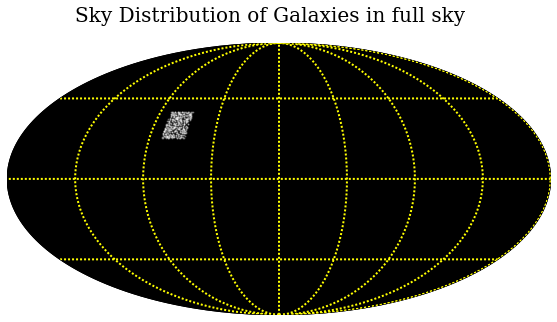

,central,core_tag,file_idx,fof_halo_tag,host_core,infall_fof_halo_center_x,infall_fof_halo_center_y,infall_fof_halo_center_z,merged,phi,row_idx,scale_factor,snapnum,theta,x,y,z
0,1,1288274280794045964,156,1077172638935,1288274280794045964,2946.767578,2242.352051,556.757874,0,1.197630,6598006,0.658035,83,1.149759,-453.236328,-1157.661255,556.736633
1,0,428086683246794272,156,-1080408066254,342518290326750042,2959.315918,2195.779785,550.033020,0,1.220551,6711931,0.651393,83,1.165848,-440.541962,-1205.951416,550.328308
2,0,378547087345718858,156,-1080408066254,342518290326752256,2958.952393,2195.921875,549.475403,1,1.220558,6711935,0.651393,83,1.165825,-440.529266,-1205.941650,550.357849
3,0,356029089208863211,156,-1080408066254,342518290326750042,2958.929443,2195.968506,548.968872,1,1.220553,6711933,0.651393,83,1.165828,-440.534149,-1205.937744,550.351746
4,0,437093882501535615,156,-1080408066254,342518290326750042,2959.155518,2195.987793,549.796570,1,1.220554,6711936,0.651393,83,1.165831,-440.534149,-1205.942627,550.349792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36180304,0,482132245302222772,174,1089950223299,459614247165369320,2981.440430,632.035156,1924.315674,0,1.420666,192353,0.356040,57,0.968608,-418.696289,-2767.900391,1924.172974
36180305,1,698305096135481358,174,1096540941758,698305096135481358,2995.800293,664.567871,2084.937500,0,1.424123,548062,0.348413,57,0.924714,-404.096008,-2735.280029,2084.898926
36180306,1,666779898743896495,150,1089951234144,666779898743896495,2978.236572,660.587158,1974.119141,0,1.418040,7175059,0.355339,57,0.951897,-421.748291,-2739.402832,1974.122803
36180307,1,770362621453945794,174,-282566891657687,770362621453945794,2983.227295,618.648865,1927.580078,0,1.422070,283373,0.354531,57,0.969942,-416.737946,-2781.359619,1927.598633


In [ ]:
# Process all matching files
single_skypatch_all_subfiles = all_subfiles_in_skypatch(target_skypatch_id)
single_skypatch_all_data = pd.concat([extract_data_single_subfile(file) for file in single_skypatch_all_subfiles], ignore_index=True)

# subfile_idx = 5
# print(single_skypatch_all_subfiles[subfile_idx])
# print(np.unique(extract_data_single_subfile(single_skypatch_all_subfiles[subfile_idx])["file_idx"]))

ra_skypatch, dec_skypatch = cosmology_utils.ra_dec(single_skypatch_all_data['x'], single_skypatch_all_data['y'], single_skypatch_all_data['z'])
plot_utils.basemap_plot(ra_skypatch, dec_skypatch)

single_skypatch_all_data

### Read cores by LC file_idx 

In [ ]:
from haccytrees.coretrees.coretree_reader import corematrix_reader
SIMULATION = haccytrees.Simulation.simulations["LastJourney"]

In [ ]:
# file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_selected_core_file_idx
# single_skypatch_all_data[file_idx_selection_criteria]
# row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]
# forest_matrices_match = forest_matrices['fof_halo_tag']#[row_indx_selected_by_file_idx, :]

In [ ]:
# file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_selected_core_file_idx
# single_skypatch_all_data["file_idx"]

In [ ]:
# row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]
# row_indx_selected_by_file_idx.shape, single_skypatch_all_data.shape
# forest_matrices_match = forest_matrices['fof_halo_tag'][row_indx_selected_by_file_idx, :]

In [ ]:
# forest_matrices.keys()#, lc_data_id = np.abs(lc_data['fof_halo_tag'])

### Core-x-LC matching

In [ ]:
time1 = time.time()

for unique_selected_core_file_idx in np.unique(single_skypatch_all_data["file_idx"])[:1]: ## REMOVE [:2]
    print ('Working with core subvolume: ', unique_selected_core_file_idx)

    core_forest_file_name = dirIn_core + "m000p.coreforest."+ str(unique_selected_core_file_idx) + ".hdf5"
    forest_matrices = corematrix_reader(core_forest_file_name, SIMULATION)
    
    file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_selected_core_file_idx
    
    row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]
    col_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]['snapnum']

    
    # match_x = forest_matrices['x'][row_indx_selected_by_file_idx, :]
    # match_y = forest_matrices['y'][row_indx_selected_by_file_idx, :]
    # match_z = forest_matrices['z'][row_indx_selected_by_file_idx, :]
    match_x = single_skypatch_all_data[file_idx_selection_criteria]["x"]
    match_y = single_skypatch_all_data[file_idx_selection_criteria]["y"]
    match_z = single_skypatch_all_data[file_idx_selection_criteria]["z"]

    # match_vx = forest_matrices['vx'][row_indx_selected_by_file_idx, :]
    # match_vy = forest_matrices['vy'][row_indx_selected_by_file_idx, :]
    # match_vz = forest_matrices['vz'][row_indx_selected_by_file_idx, :]

    match_vx = forest_matrices['vx'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx] ## velocity is not from LC
    match_vy = forest_matrices['vy'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx] ## velocity is not from LC
    match_vz = forest_matrices['vz'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx] ## velocity is not from LC

    # match_tag = forest_matrices['fof_halo_tag'][row_indx_selected_by_file_idx, :]
    # match_central = forest_matrices['central'][row_indx_selected_by_file_idx, :]
    # match_merged = forest_matrices['merged'][row_indx_selected_by_file_idx, :]
    # match_state = forest_matrices['core_state'][row_indx_selected_by_file_idx, :]

    match_tag = forest_matrices['fof_halo_tag'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx]
    match_central = forest_matrices['central'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx]
    match_merged = forest_matrices['merged'][row_indx_selected_by_file_idx, col_indx_selected_by_file_idx]


    match_state_row = forest_matrices['core_state'][row_indx_selected_by_file_idx, :]
    
    
    ### FOR ANY HOST PROPERTIES, USE THIS SNIPPET. 

    mask = forest_matrices['top_host_row'] > 1
    _full_idx = (forest_matrices['top_host_row'][mask], forest_matrices['snapnum'][mask])
    parent_fof_mass = np.empty_like(forest_matrices['infall_fof_halo_mass'])
    parent_fof_mass[:] = -1
    parent_fof_mass[mask] = forest_matrices['infall_fof_halo_mass'][_full_idx]
    match_fof_halo_mass_row = parent_fof_mass[row_indx_selected_by_file_idx, :] ## mass of the host halo 

    ############################################
    
    time_infall = cores_analysis.infall_time_alphaq(match_state_row, alphaq_analysis_age)
    t50_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.5)
    t25_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass_row, alphaq_analysis_age, 0.25)
    peak_mass = cores_analysis.peak_mass_HACC(match_fof_halo_mass_row)
    rank_peak_mass = cores_analysis.mass_rank_alphaq(match_fof_halo_mass_row, V_alphaq)
    
    
    mass_time_central_z0 =  np.array([ t50_a1[match_state[:, -1] == 0], peak_mass[match_state[:, -1] == 0]]).T
    mass_time_satellite_z0 =  np.array([ t50_a1[match_state[:, -1] == 1], peak_mass[match_state[:, -1] == 1]]).T
    mass_time_merged_z0 =  np.array([ t50_a1[match_state[:, -1] == 2], peak_mass[match_state[:, -1] == 2]]).T
    #############################
    ## Use the above for 'match summary'
    ## Append from each loop. 
    

delta_time = (time.time() - time1)/3600
print('Time: %.2f hr'%delta_time)

Working with core subvolume:  58


/home/nramachandra/anaconda3/envs/env_jax_2024/lib/python3.9/site-packages/haccytrees/coretrees/coretree_reader.py:116: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as forest_file:


Time: 0.12 hr


In [ ]:
match_tag.shape

(210,)

In [ ]:
match_x.shape, match_y.shape, match_z.shape, match_vx.shape, match_vy.shape, match_vz.shape, match_tag.shape, match_central.shape, match_merged.shape, match_state.shape, match_fof_halo_mass.shape

((210,),
 (210,),
 (210,),
 (210,),
 (210,),
 (210,),
 (210,),
 (210,),
 (210,),
 (210, 101),
 (210, 101))

In [ ]:
file_idx_selection_criteria0 = single_skypatch_all_data["file_idx"] == unique_selected_core_file_idx
row_indx_selected_by_file_idx0 = single_skypatch_all_data[file_idx_selection_criteria0]["row_idx"]
col_indx_selected_by_file_idx0 = single_skypatch_all_data[file_idx_selection_criteria0]['snapnum']
# print(10*'=--=')
# print(file_idx_selection_criteria0, row_indx_selected_by_file_idx0)
# print(row_indx_selected_by_file_idx0, col_indx_selected_by_file_idx0)
# print(10*'=--=')
# single_skypatch_all_data[file_idx_selection_criteria]["vx"]
print(single_skypatch_all_data["x"][file_idx_selection_criteria0].values[0])
# forest_matrices['snapnum']
print(10*'=--=')
print(forest_matrices['x'][row_indx_selected_by_file_idx0, col_indx_selected_by_file_idx0])

-2231.9988
=--==--==--==--==--==--==--==--==--==--=
[1168.175 1261.024 1161.554 1151.237 1093.667 1052.675 1236.743 1096.753
 1083.708 1153.373 1114.573 1267.192 1224.225 1085.545 1015.601 1059.436
 1193.845 1261.775 1176.971 1248.624 1270.925 1177.252 1175.068 1242.201
 1181.021 1248.22  1211.454 1201.322 1266.558 1225.276 1255.515 1219.947
 1222.48  1247.446 1257.164 1176.02  1097.548 1172.863 1163.01  1140.926
 1015.67  1163.855 1113.001 1242.089 1158.542 1138.512 1227.147 1227.554
 1121.789 1142.123 1133.617 1112.841 1130.896 1224.657 1120.494 1151.844
 1221.573 1250.943 1222.139 1116.514 1149.58  1118.081 1222.4   1148.359
 1152.725 1116.895 1147.387 1121.205 1145.725 1153.403 1123.468 1254.539
 1262.442 1201.641 1089.145 1179.781 1167.641 1167.322 1097.858 1168.551
 1179.033 1263.695 1263.254 1189.461 1177.174 1095.975 1206.947 1207.142
 1269.751 1270.745 1264.498 1092.739 1072.109 1208.325 1172.417 1091.292
 1207.729 1083.094 1174.284 1182.995 1180.608 1254.375 1195.276 1267.534

In [ ]:
peak_mass.shape, rank_peak_mass.shape, mass_time_central_z0.shape, mass_time_satellite_z0.shape, mass_time_merged_z0.shape

((210,), (210,), (98, 2), (30, 2), (82, 2))

In [ ]:
def process_core_file(unique_core_idx, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq):
    print(f"Processing core subvolume: {unique_core_idx}")

    # Generate the core forest file name and load matrices
    core_forest_file_name = f"{dirIn_core}m000p.coreforest.{unique_core_idx}.hdf5"
    forest_matrices = corematrix_reader(core_forest_file_name, SIMULATION)

    # Selection criteria and indices
    file_idx_selection_criteria = single_skypatch_all_data["file_idx"] == unique_core_idx
    row_indx_selected_by_file_idx = single_skypatch_all_data[file_idx_selection_criteria]["row_idx"]

    # Batch index all relevant arrays
    match_data = {key: forest_matrices[key][row_indx_selected_by_file_idx, :] for key in 
                  ['x', 'y', 'z', 'vx', 'vy', 'vz', 'fof_halo_tag', 'central', 'merged', 'core_state']}

    # Host properties computation
    mask = forest_matrices['top_host_row'] > 1
    _full_idx = (forest_matrices['top_host_row'][mask], forest_matrices['snapnum'][mask])
    parent_fof_mass = np.empty_like(forest_matrices['infall_fof_halo_mass'])
    parent_fof_mass[:] = -1
    parent_fof_mass[mask] = forest_matrices['infall_fof_halo_mass'][_full_idx]
    match_fof_halo_mass = parent_fof_mass[row_indx_selected_by_file_idx, :]

    # Analysis computations
    match_state = match_data['core_state']
    time_infall = cores_analysis.infall_time_alphaq(match_state, alphaq_analysis_age)
    t50_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass, alphaq_analysis_age, 0.5)
    t25_a1 = cores_analysis.mass_time_alphaq(match_fof_halo_mass, alphaq_analysis_age, 0.25)
    peak_mass = cores_analysis.peak_mass_HACC(match_fof_halo_mass)
    rank_peak_mass = cores_analysis.mass_rank_alphaq(match_fof_halo_mass, V_alphaq)

    # Summaries
    mass_time_central_z0 = np.array([t50_a1[match_state[:, -1] == 0], peak_mass[match_state[:, -1] == 0]]).T
    mass_time_satellite_z0 = np.array([t50_a1[match_state[:, -1] == 1], peak_mass[match_state[:, -1] == 1]]).T
    mass_time_merged_z0 = np.array([t50_a1[match_state[:, -1] == 2], peak_mass[match_state[:, -1] == 2]]).T

    return match_data, mass_time_central_z0, mass_time_satellite_z0, mass_time_merged_z0

# Function for distributed processing with MPI
def mpi_process(single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Get unique core indices and distribute work among ranks
    unique_core_idxs = np.unique(single_skypatch_all_data["file_idx"])
    local_indices = np.array_split(unique_core_idxs, size)[rank]

    print(f"[Rank {rank}] Assigned {len(local_indices)} unique_core_idxs out of {len(unique_core_idxs)} total.")

    # Local processing on each rank
    local_results = []
    for idx in local_indices:
        print(f"[Rank {rank}] Processing index {i + 1}/{len(local_indices)}: unique_core_idx={idx}")
        result = process_core_file(idx, single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq)
        local_results.append(result)

    # Gather all results at the root process
    print(f"[Rank {rank}] Finished processing. Gathering results...")
    all_results = comm.gather(local_results, root=0)

    if rank == 0:
        # Combine all results from all ranks
        print("[Rank 0] Gathering results from all ranks...")
        match_data_list = []
        central, satellite, merged = [], [], []
        for rank_results in all_results:
            for match_data, cent, sat, merg in rank_results:
                match_data_list.append(match_data)
                central.append(cent)
                satellite.append(sat)
                merged.append(merg)
        
        # Concatenate results
        print("[Rank 0] Concatenating results...")
        central = np.vstack(central)
        satellite = np.vstack(satellite)
        merged = np.vstack(merged)
        print("[Rank 0] Results concatenated successfully.")

        return match_data_list, central, satellite, merged
    else:
        print(f"[Rank {rank}] All results sent to root.")
        return None
    
    
# Main execution
# if __name__ == "__main__":
    # Replace these with actual data
    # single_skypatch_all_data = ...  # Input data
    # forest_matrices = ...  # Forest matrices
    # alphaq_analysis_age = ...  # Alpha-Q analysis parameter
    # V_alphaq = ...  # Alpha-Q velocity

time1 = time.time()
results = mpi_process(single_skypatch_all_data, dirIn_core, SIMULATION, alphaq_analysis_age, V_alphaq)
delta_time = (time.time() - time1) / 3600

# Root process outputs the results
if MPI.COMM_WORLD.Get_rank() == 0:
    match_data_list, central_data, satellite_data, merged_data = results
    print(f"Match data list size: {len(match_data_list)}")
    print(f"Central data shape: {central_data.shape}")
    print(f"Satellite data shape: {satellite_data.shape}")
    print(f"Merged data shape: {merged_data.shape}")
    print(f"Time: {delta_time:.2f} hr")

In [ ]:
mass_time_2 = np.array([ t50_a1[match_state[:, -1] == 2], peak_mass[match_state[:, -1] == 2]]).T

In [ ]:
mass_time_0.shape, t50_a1.shape, mass_time_1.shape, mass_time_2.shape, 123458 + 91135 + 117920

((123458, 2), (332513,), (91135, 2), (117920, 2), 332513)

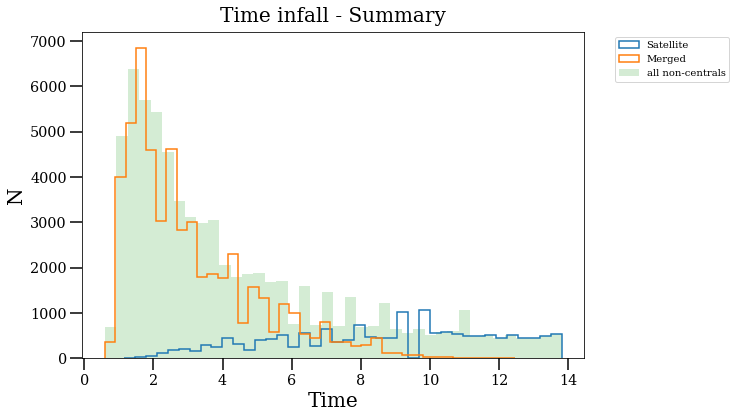

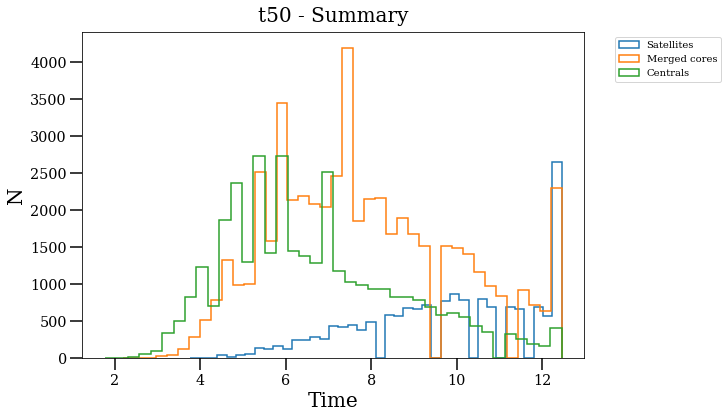

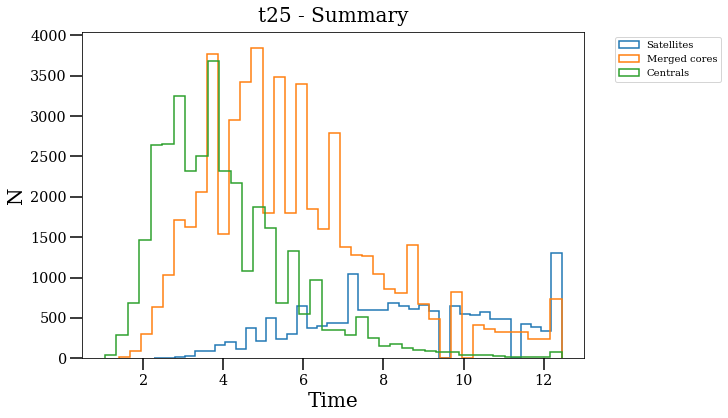

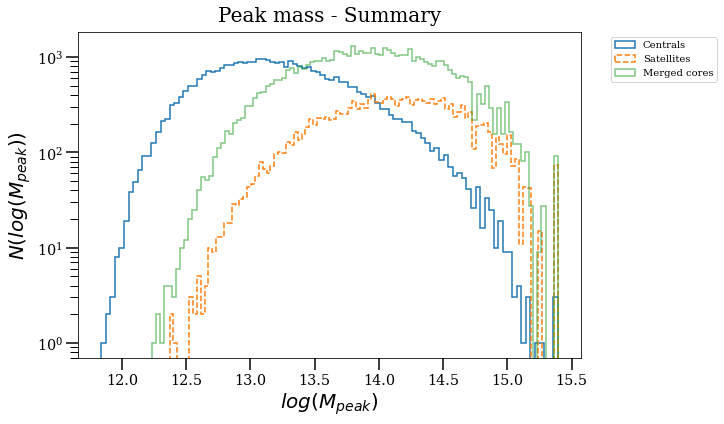

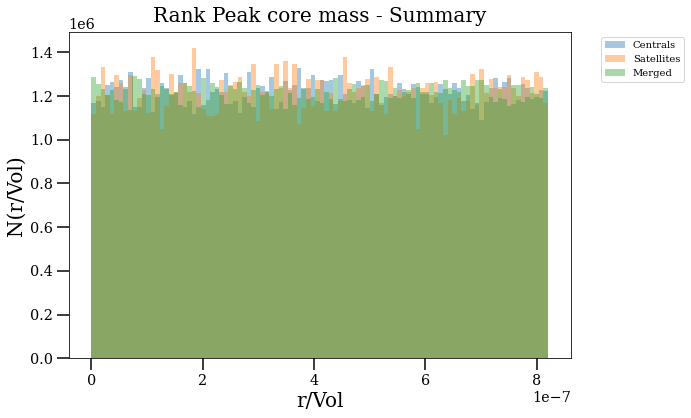

In [ ]:
plot_utils.plot_summary_histograms(time_infall, match_state, "Time infall")
plot_utils.plot_summary_histograms(t50_a1, match_state, 't50')
plot_utils.plot_summary_histograms(t25_a1, match_state, 't25')
plot_utils.plot_summary_histograms(peak_mass, match_state, "Peak mass")
plot_utils.plot_summary_histograms(rank_peak_mass, match_state, "Rank Peak core mass")

In [ ]:
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Central")
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Satellite")
plot_utils.plot_accretion_histories(alphaq_analysis_age, fof_halo_mass, core_status, "Merged")
plot_utils.plot_core_status(core_status)


#############################

time_infall = cores_analysis.infall_time_alphaq(core_status, alphaq_analysis_age)
t50_a1 = cores_analysis.mass_time_alphaq(fof_halo_mass, alphaq_analysis_age, 0.5)
t25_a1 = cores_analysis.mass_time_alphaq(fof_halo_mass, alphaq_analysis_age, 0.25)
peak_mass = cores_analysis.peak_mass_HACC(fof_halo_mass)
rank_peak_mass = cores_analysis.mass_rank_alphaq(fof_halo_mass, V_alphaq)

#############################

# plot_utils.plot_summary_histograms(time_infall, core_status, "Time infall")
# plot_utils.plot_summary_histograms(t50_a1, core_status, 't50')
# plot_utils.plot_summary_histograms(t25_a1, core_status, 't25')
# plot_utils.plot_summary_histograms(peak_mass, core_status, "Peak mass")
# plot_utils.plot_summary_histograms(rank_peak_mass, core_status, "Rank Peak core mass")